In [1]:
# https://youtu.be/XyX5HNuv-xE
"""
Author: Dr. Sreenivas Bhattiprolu
Multiclass semantic segmentation using U-Net
Including segmenting large images by dividing them into smaller patches 
and stiching them back
To annotate images and generate labels, you can use APEER (for free):
www.apeer.com 
"""

import os
import glob
import cv2
import numpy as np
import random
from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.utils import normalize


# from keras.utils import to_categorical
# from keras.metrics import MeanIoU
# from keras.utils import normalize

In [2]:
#Resizing images, if needed
SIZE_X = 512 
SIZE_Y = 512
n_classes=10 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

for directory_path in glob.glob(r"C:\Users\yiju\Desktop\data\train\image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)
train_images.shape

(4000, 512, 512)

In [3]:

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(r"C:\Users\yiju\Desktop\data\train\mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
train_masks.shape

(4000, 512, 512)

In [4]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


C:\Users\yiju\Anaconda3\envs\tf-gpu-37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [5]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))


Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [6]:
###############################################################
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

C:\Users\yiju\Anaconda3\envs\tf-gpu-37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[0 0 0 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Class weights are...: [0.14097667 2.97373901 2.5678068  2.99468684 2.32854274 8.88902679
 7.20769816 7.06197955 6.12945081 1.1607034 ]


In [7]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers. 
"""
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [8]:
# loss functions

def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.sum(K.dot(targets, inputs))    
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def dice_coef(y_true, y_pred, smooth=1e-7):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    print(y_true.shape)
    y_true_f = K.flatten(y_true)
    print(y_true_f.shape)
    y_pred_f = K.flatten(y_pred)
    # print(y_pred_f.shape)
    intersect = K.sum(y_true_f * y_pred_f)
    denom = K.sum(y_true_f) + K.sum(y_pred_f)
    return ((2. * intersect + smooth)/ (denom + smooth))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

def dice_coef2(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 1e-7
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=10):
    dice=numLabels
    for index in range(numLabels):
        dice -= dice_coef2(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice / numLabels

def BCEdice_coef_multilabel(y_true, y_pred, numLabels=10):
    dice=numLabels
    BCE =  binary_crossentropy(y_true, y_pred)
    for index in range(numLabels):
        dice -= dice_coef2(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice / numLabels + BCE

import tensorflow as tf
def gen_dice(y_true, y_pred, eps=1e-6):
    """both tensors are [b, h, w, classes] and y_pred is in logit form"""

    # [b, h, w, classes]
    pred_tensor = tf.nn.softmax(y_pred)
    y_true_shape = tf.shape(y_true)

    # [b, h*w, classes]
    y_true = tf.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2], y_true_shape[3]])
    y_pred = tf.reshape(pred_tensor, [-1, y_true_shape[1]*y_true_shape[2], y_true_shape[3]])

    # [b, classes]
    # count how many of each class are present in 
    # each image, if there are zero, then assign
    # them a fixed weight of eps
    counts = tf.reduce_sum(y_true, axis=1)
    weights = 1. / (counts ** 2)
    weights = tf.where(tf.math.is_finite(weights), weights, eps)

    multed = tf.reduce_sum(y_true * y_pred, axis=1)
    summed = tf.reduce_sum(y_true + y_pred, axis=1)

    # [b]
    numerators = tf.reduce_sum(weights*multed, axis=-1)
    denom = tf.reduce_sum(weights*summed, axis=-1)
    dices = 1. - 2. * numerators / denom
    dices = tf.where(tf.math.is_finite(dices), dices, tf.zeros_like(dices))
    return tf.reduce_mean(dices)


def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

In [9]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [10]:
#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, y_val_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

Epoch 1/100
450/450 [==============================] - 100s 222ms/step - loss: 1.2552 - accuracy: 0.7064 - val_loss: 1.1350 - val_accuracy: 0.7067
Epoch 2/100
450/450 [==============================] - 100s 222ms/step - loss: 1.0430 - accuracy: 0.7137 - val_loss: 1.0290 - val_accuracy: 0.7124
Epoch 3/100
450/450 [==============================] - 100s 223ms/step - loss: 0.9706 - accuracy: 0.7223 - val_loss: 0.9439 - val_accuracy: 0.7214
Epoch 4/100
450/450 [==============================] - 100s 223ms/step - loss: 0.9071 - accuracy: 0.7319 - val_loss: 0.9039 - val_accuracy: 0.7298
Epoch 5/100
450/450 [==============================] - 100s 223ms/step - loss: 0.8534 - accuracy: 0.7404 - val_loss: 0.8575 - val_accuracy: 0.7399
Epoch 6/100
450/450 [==============================] - 100s 223ms/step - loss: 0.8030 - accuracy: 0.7494 - val_loss: 0.7929 - val_accuracy: 0.7560
Epoch 7/100
450/450 [==============================] - 100s 223ms/step - loss: 0.7357 - accuracy: 0.7638 - val_loss: 0

450/450 [==============================] - 298s 662ms/step - loss: 0.1886 - accuracy: 0.9361 - val_loss: 0.2605 - val_accuracy: 0.9192
Epoch 55/100
450/450 [==============================] - 164s 364ms/step - loss: 0.1872 - accuracy: 0.9366 - val_loss: 0.2669 - val_accuracy: 0.9180
Epoch 56/100
450/450 [==============================] - 161s 357ms/step - loss: 0.1899 - accuracy: 0.9359 - val_loss: 0.3365 - val_accuracy: 0.8975
Epoch 57/100
450/450 [==============================] - 114s 253ms/step - loss: 0.1942 - accuracy: 0.9344 - val_loss: 0.2531 - val_accuracy: 0.9209
Epoch 58/100
450/450 [==============================] - 99s 220ms/step - loss: 0.1830 - accuracy: 0.9378 - val_loss: 0.2693 - val_accuracy: 0.9174
Epoch 59/100
450/450 [==============================] - 99s 220ms/step - loss: 0.1838 - accuracy: 0.9376 - val_loss: 0.2586 - val_accuracy: 0.9189
Epoch 60/100
450/450 [==============================] - 99s 220ms/step - loss: 0.1827 - accuracy: 0.9378 - val_loss: 0.2566 - v

In [11]:
############################################################
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_val, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")

13/13 [==============================] - 4s 307ms/step - loss: 0.2379 - accuracy: 0.9249
Accuracy is =  92.4894392490387 %


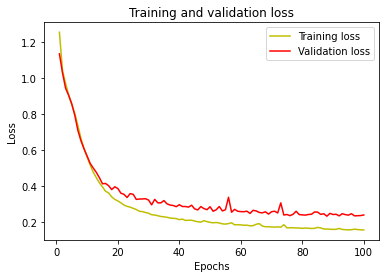

In [12]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

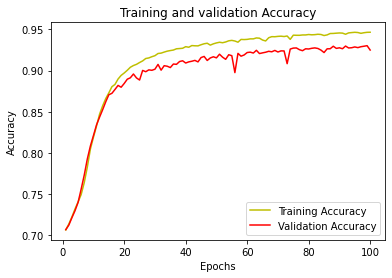

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
##################################
#model = get_model()
model.load_weights('test.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IOU
y_pred=model.predict(X_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [15]:
#Using built in keras function
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_val[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

Mean IoU = 0.67004335
[[7.2962475e+07 1.0754100e+05 1.7663000e+05 1.4674100e+05 7.6273000e+04
  4.6764000e+04 2.2135000e+04 2.1841000e+04 4.0783000e+04 5.0656900e+05]
 [1.5801800e+05 2.7043740e+06 9.2958000e+04 4.4485000e+04 3.5183000e+04
  1.3555800e+05 1.2920000e+03 4.3855000e+04 6.5950000e+03 3.0435100e+05]
 [1.7513500e+05 1.4185100e+05 3.1377340e+06 7.6414000e+04 3.9211000e+04
  1.0685000e+04 7.3933000e+04 3.1100000e+03 8.4293000e+04 4.4770300e+05]
 [1.7671900e+05 3.4226000e+04 2.7972000e+04 2.8206200e+06 3.2472000e+04
  5.5281000e+04 6.0498000e+04 1.8860000e+03 3.8390000e+03 1.9623000e+05]
 [2.3771600e+05 4.7506000e+04 5.0517000e+04 1.3523600e+05 3.0671360e+06
  4.2170000e+03 7.7210000e+03 1.3027300e+05 6.9054000e+04 4.9604800e+05]
 [3.8760000e+04 7.2946000e+04 7.4340000e+03 5.7016000e+04 2.8140000e+03
  1.0784950e+06 6.2890000e+03 6.8040000e+03 2.3947000e+04 2.9479000e+04]
 [6.4717000e+04 4.5170000e+03 6.8047000e+04 1.3769200e+05 3.5970000e+03
  1.5377000e+04 1.1074890e+06 1.9788

In [16]:
for i in range(n_classes):
    class_IoU = values[i,i]/(sum([values[i,j] for j in range(n_classes)])
                             +sum([values[j,i] for j in range(n_classes)])
                             -values[i,i])
    print(f"IoU for class {i} is: ", class_IoU)

IoU for class 0 is:  0.9661553336778235
IoU for class 1 is:  0.6377557686040222
IoU for class 2 is:  0.6141540651324693
IoU for class 3 is:  0.6462780960341453
IoU for class 4 is:  0.6363636552252849
IoU for class 5 is:  0.6315919235503771
IoU for class 6 is:  0.649895194190026
IoU for class 7 is:  0.6268619810635682
IoU for class 8 is:  0.6156733556951464
IoU for class 9 is:  0.6757046346054064


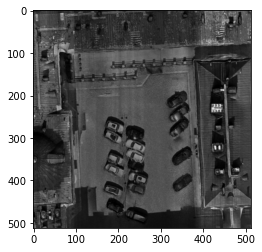

In [17]:
plt.imshow(train_images[1, :,:,0], cmap='gray')

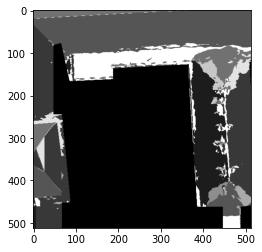

In [18]:
plt.imshow(train_masks[1], cmap='gray')

In [19]:
#Predict on a few images

#Capture training image info as a list
test_images = []

for directory_path in glob.glob(r"C:\Users\yiju\Desktop\data\test\image"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0)       
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_images.append(img)
       
#Convert list to array for machine learning processing        
test_images = np.array(test_images)
test_images.shape

(999, 512, 512)

In [20]:
#Capture mask/label info as a list
test_masks = [] 
for directory_path in glob.glob(r"C:\Users\yiju\Desktop\data\test\mask"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tif")):
        mask = cv2.imread(mask_path, 0)       
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        test_masks.append(mask)
        
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)
test_masks.shape

(999, 512, 512)

In [21]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

np.unique(test_masks_encoded_original_shape)

#################################################
test_images = np.expand_dims(test_images, axis=3)
test_images = normalize(test_images, axis=1)

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

In [22]:
test_masks_cat = to_categorical(test_masks_input, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((test_masks_input.shape[0], test_masks_input.shape[1], test_masks_input.shape[2], n_classes))


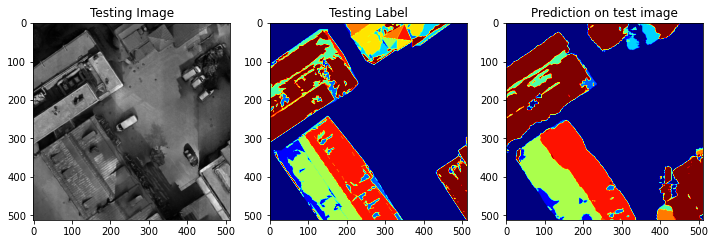

In [45]:
#model = get_model()
#model.load_weights('???.hdf5')  
test_img_number = random.randint(0, len(test_images))
test_img = test_images[test_img_number]
ground_truth=test_masks_input[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [39]:
#Predict on large image

#Apply a trained model on large image


large_image = cv2.imread(r'C:\Users\yiju\Desktop\merge2.tif', 0)
#This will split the image into small images of shape [3,3]
img_size = 512
patches = patchify(large_image, (img_size, img_size), step=img_size)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print('\r', i,j, end='')        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], img_size,img_size) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

TypeError: `arr_in` must be a numpy ndarray

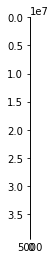

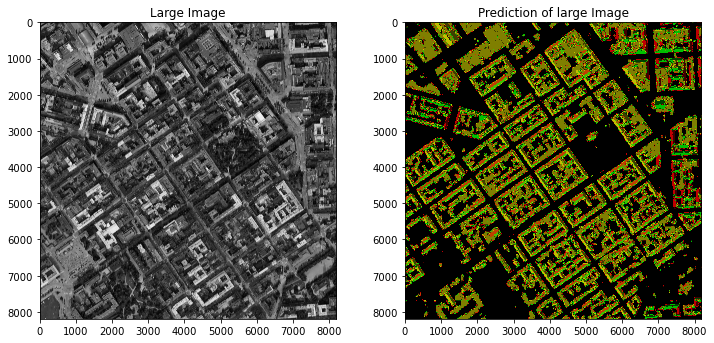

In [33]:
from matplotlib.colors import ListedColormap
colormap =  ListedColormap(np.array([
    [0, 0, 0],
    
 [127 + 64, 0, 0],
 [127 - 64, 0, 0],
 [0, 127 + 64, 0],
 [0, 127 - 64, 0],
 [127 + 64, 127 + 64, 0],
 [127 - 64, 127 + 64, 0],
 [127 + 64, 127 - 64, 0],
 [127 - 64, 127 - 64, 0],
 [127, 127, 0],
           ])/255)

cv2.imwrite(r"C:\Users\yiju\Desktop\test_result.tif",reconstructed_image)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

fig = plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap=colormap)
plt.show()
plt.imsave(fname=r"C:\Users\yiju\Desktop\test_result_rgb.png", arr=reconstructed_image,
           cmap=colormap, format='png')